In [22]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import IDR_utils
import os
import numpy as np
from stardist import random_label_cmap, _draw_polygons
lbl_cmap = random_label_cmap()
from stardist.models import StarDist2D
from glob import glob
import multiprocessing as mp
import ImportImg
from im_ClearBorder import im_ClearBorder
from im_segment import im_segment
import pandas as pd
from Pad_n_Save import Pad_n_Save
from pathvalidate import sanitize_filename

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Obtaining the source images

#### Define the compound and Channel of interest.
#### Define the path of the source images

In [4]:
idx_file = './idr0016-screenA-annotation.csv'
df = pd.read_csv (idx_file)
Comp_names =  df['Compound Name']
unique_Comp_names = Comp_names.unique()
Comp_Avail = [name for name in unique_Comp_names if (type(name)==str and len(name)>0 and name!='DMSO')]
print('No. of compounds available =',len(Comp_Avail))
CompoundsOfInterest = Comp_Avail[0:2]
print('No. of compounds selected =',len(CompoundsOfInterest))


No. of compounds available = 30346
No. of compounds selected = 2


In [5]:
# Getting a list of image paths and ground truths by consulting the IDR database

# CompoundsOfInterest=['chlorphenamine','estradiol','propoxycaine']

ChannelOfInterest=['Hoechst'] # choose only 1
# ChannelOfInterest=['Hoechst', 'ERSyto', 'ERSytoBleed', 'Ph_golgi', 'Mito']

# Local source of images or path where images will be downloaded
# Local_ImgPath = os.path.abspath(r'/gpfs0/home/jokhun/Pro 1/U2OS small mol screening/RawImages')
Local_ImgPath = os.path.abspath(r'\\deptnas.nus.edu.sg\BIE\MBELab\jokhun\Pro 1\U2OS small mol screening\RawImages')

# idx_file = None # Use None to download the idx_file from IDR's github
idx_file = idx_file
# idx_file = './idr0016-screenA-annotation.csv'

# Checking which all files have to be downloaded
Targets_dict={}
dwnld_args_dict={}
for CompoundOfInterest in CompoundsOfInterest:
    Targets_dict[CompoundOfInterest], dwnld_args_dict[CompoundOfInterest] = IDR_utils.IDR_ImgAvailChk([CompoundOfInterest], ChannelOfInterest, Local_ImgPath, idx_file)

No. of targets identified =  8
No. of files to be downloaded =  0
No. of targets identified =  8
No. of files to be downloaded =  0


In [6]:
Downld_missing_files = False
if Downld_missing_files:
    for CompoundOfInterest in CompoundsOfInterest:
        dwnld_args = dwnld_args_dict[CompoundOfInterest]
        IDR_utils.IDR_ImageFetcher (dwnld_args)
else:
    for CompoundOfInterest in CompoundsOfInterest:
        Targets = Targets_dict[CompoundOfInterest]
        dwnld_args = dwnld_args_dict[CompoundOfInterest]
        plates2remove=[(os.path.basename(arg[0]))[0:5] for arg in dwnld_args]
        Targets=[Target for Target in Targets if Target['Plate'] not in plates2remove]
        Targets_dict[CompoundOfInterest] = Targets

#### Define the destination of the segmented images

In [ ]:
delete_existing_folders = False
Master_SaveDir_of_SegmentedImg = os.path.abspath('/gpfs0/home/jokhun/Pro 1/U2OS small mol screening/Segmented_SmallMol')
# Master_SaveDir_of_SegmentedImg = os.path.abspath(r'\\deptnas.nus.edu.sg\BIE\MBELab\jokhun\Pro 1\U2OS small mol screening\Segmented_SmallMol')

if delete_existing_folders:
    assert len(ChannelOfInterest) == 1, "ChannelOfInterest should contain only one value prior to segmentation"
    for CompoundOfInterest in CompoundsOfInterest:
        os.rmdir(os.path.join(Master_SaveDir_of_SegmentedImg,sanitize_filename(CompoundOfInterest)))

In [7]:
assert len(ChannelOfInterest) == 1, "ChannelOfInterest should contain only one value prior to segmentation"

# Master_SaveDir_of_SegmentedImg = os.path.abspath('/gpfs0/home/jokhun/Pro 1/U2OS small mol screening/Segmented_SmallMol')
Master_SaveDir_of_SegmentedImg = os.path.abspath(r'\\deptnas.nus.edu.sg\BIE\MBELab\jokhun\Pro 1\U2OS small mol screening\Segmented_SmallMol')

SaveDir_of_SegmentedImg_dict = {}
for CompoundOfInterest in CompoundsOfInterest:
    SaveDir_of_SegmentedImg_dict[CompoundOfInterest]=os.path.join(Master_SaveDir_of_SegmentedImg,sanitize_filename(CompoundOfInterest)) 
# Checking if these images have already been segmented before and updating the list of images accordingly
    TargetPlates=np.unique([Target['Plate'] for Target in Targets_dict[CompoundOfInterest]])
    try: 
        ExistingPlates=np.unique([name[0:5] for name in os.listdir(SaveDir_of_SegmentedImg_dict[CompoundOfInterest])])
    except: 
        os.mkdir(SaveDir_of_SegmentedImg_dict[CompoundOfInterest])
        ExistingPlates=np.array([])
    TargetPlates=[TargetPlate for TargetPlate in TargetPlates if TargetPlate not in ExistingPlates]
    Targets_dict[CompoundOfInterest]=[Target for Target in Targets_dict[CompoundOfInterest] if Target['Plate'] in TargetPlates]


C:\Users\biejds\Anaconda3\envs\StarDist\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


In [8]:
# Generating list of files to be imported for segmentation
SourcePaths = []
ImportDetails = []  # will be useful for naming crops later
for CompoundOfInterest in CompoundsOfInterest:
    Targets = Targets_dict[CompoundOfInterest]
    for Target in Targets:
        source_folder = os.path.abspath(os.path.join(Local_ImgPath,f"{Target['Plate']}-{ChannelOfInterest[0]}"))
        Well = Target['Well'].lower()
        if len(Well)<3:
            Well = str(Well[0]+'0'+Well[1])
        Well = str('_'+Well+'_')
        files = [file for file in os.listdir(source_folder) if Well in file]
        for file in files:
            SourcePaths.append(os.path.abspath(os.path.join(source_folder,file))) 
            ImportDetails.append({'Plate':Target['Plate'], 'Well':Well, 'File':file, 'Compound Name':Target['Compound Name']})
        
print('No. of files to be segmented = ', str(len(SourcePaths)))

No. of files to be segmented =  48


In [9]:
# Clearing memory
del Targets, TargetPlates, ExistingPlates, plates2remove, dwnld_args, source_folder, Well, files, file
del Targets_dict, dwnld_args_dict, SaveDir_of_SegmentedImg_dict

# StarDist

No. of files to be segmented =  48

1st file_path :
 \\deptnas.nus.edu.sg\BIE\MBELab\jokhun\Pro 1\U2OS small mol screening\RawImages\24277-Hoechst\cdp2bioactives_a02_s3_w16c05ec87-dac8-4757-8dc1-6780b3199ac9.tif

Destination master directory of segmented images :
 \\deptnas.nus.edu.sg\BIE\MBELab\jokhun\Pro 1\U2OS small mol screening\Segmented_SmallMol


Text(0.5, 1.0, 'Source image')

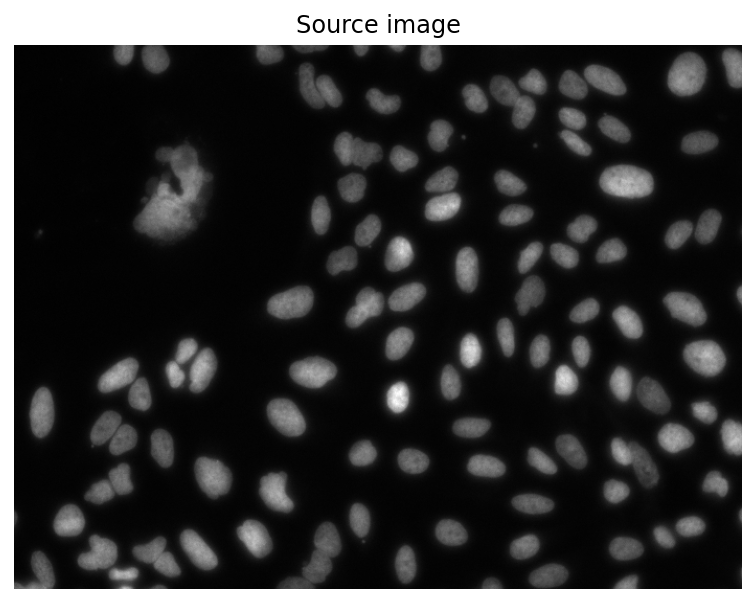

In [10]:
X_Paths = SourcePaths
Segmented_dir = Master_SaveDir_of_SegmentedImg
print('No. of files to be segmented = ', str(len(SourcePaths)))
print('\n1st file_path :\n', X_Paths[0])
print('\nDestination master directory of segmented images :\n', Segmented_dir)

with mp.Pool() as pool:
    X = pool.map(ImportImg.Import_GrayImg,[path for path in X_Paths])

plt.figure(figsize=(8,5))
plt.imshow(X[0],cmap='gray', norm=matplotlib.colors.Normalize());   plt.axis('off'); plt.title('Source image')


In [11]:
# Clearing memory
del X_Paths, SourcePaths

# Defining weights to load

In [12]:
Use_custom_model = True

if Use_custom_model:
#     ModelDir = os.path.abspath('/gpfs0/home/jokhun/Pro 1/U2OS small mol screening/StarDist_Segmentation')
    ModelDir = os.path.abspath(r'\\deptnas.nus.edu.sg\BIE\MBELab\jokhun\Pro 1\U2OS small mol screening\StarDist_Segmentation')
    ModelName = 'stardist'
    # Not used if Use_custom_model is set to flase. 
    # The in-built 2D_versatile_fluo weights is then used
    
    model = StarDist2D(None, name=ModelName, basedir=ModelDir)
    print('\nLoaded custom weights save in :\n',str(os.path.join(ModelDir,ModelName)))
else:
    model = StarDist2D.from_pretrained('2D_versatile_fluo')
    print("\nLoaded pretrained weights from in-built '2D_versatile_fluo'")


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.768265, nms_thresh=0.3.

Loaded custom weights save in :
 \\deptnas.nus.edu.sg\BIE\MBELab\jokhun\Pro 1\U2OS small mol screening\StarDist_Segmentation\stardist


# Prediction
Make sure the input images are normalized before passing to the model.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [13]:
# label, detail = model.predict_instances(x)

predictions = [model.predict_instances(x) for x in X]
Labels ,details = map(list,zip(*predictions))


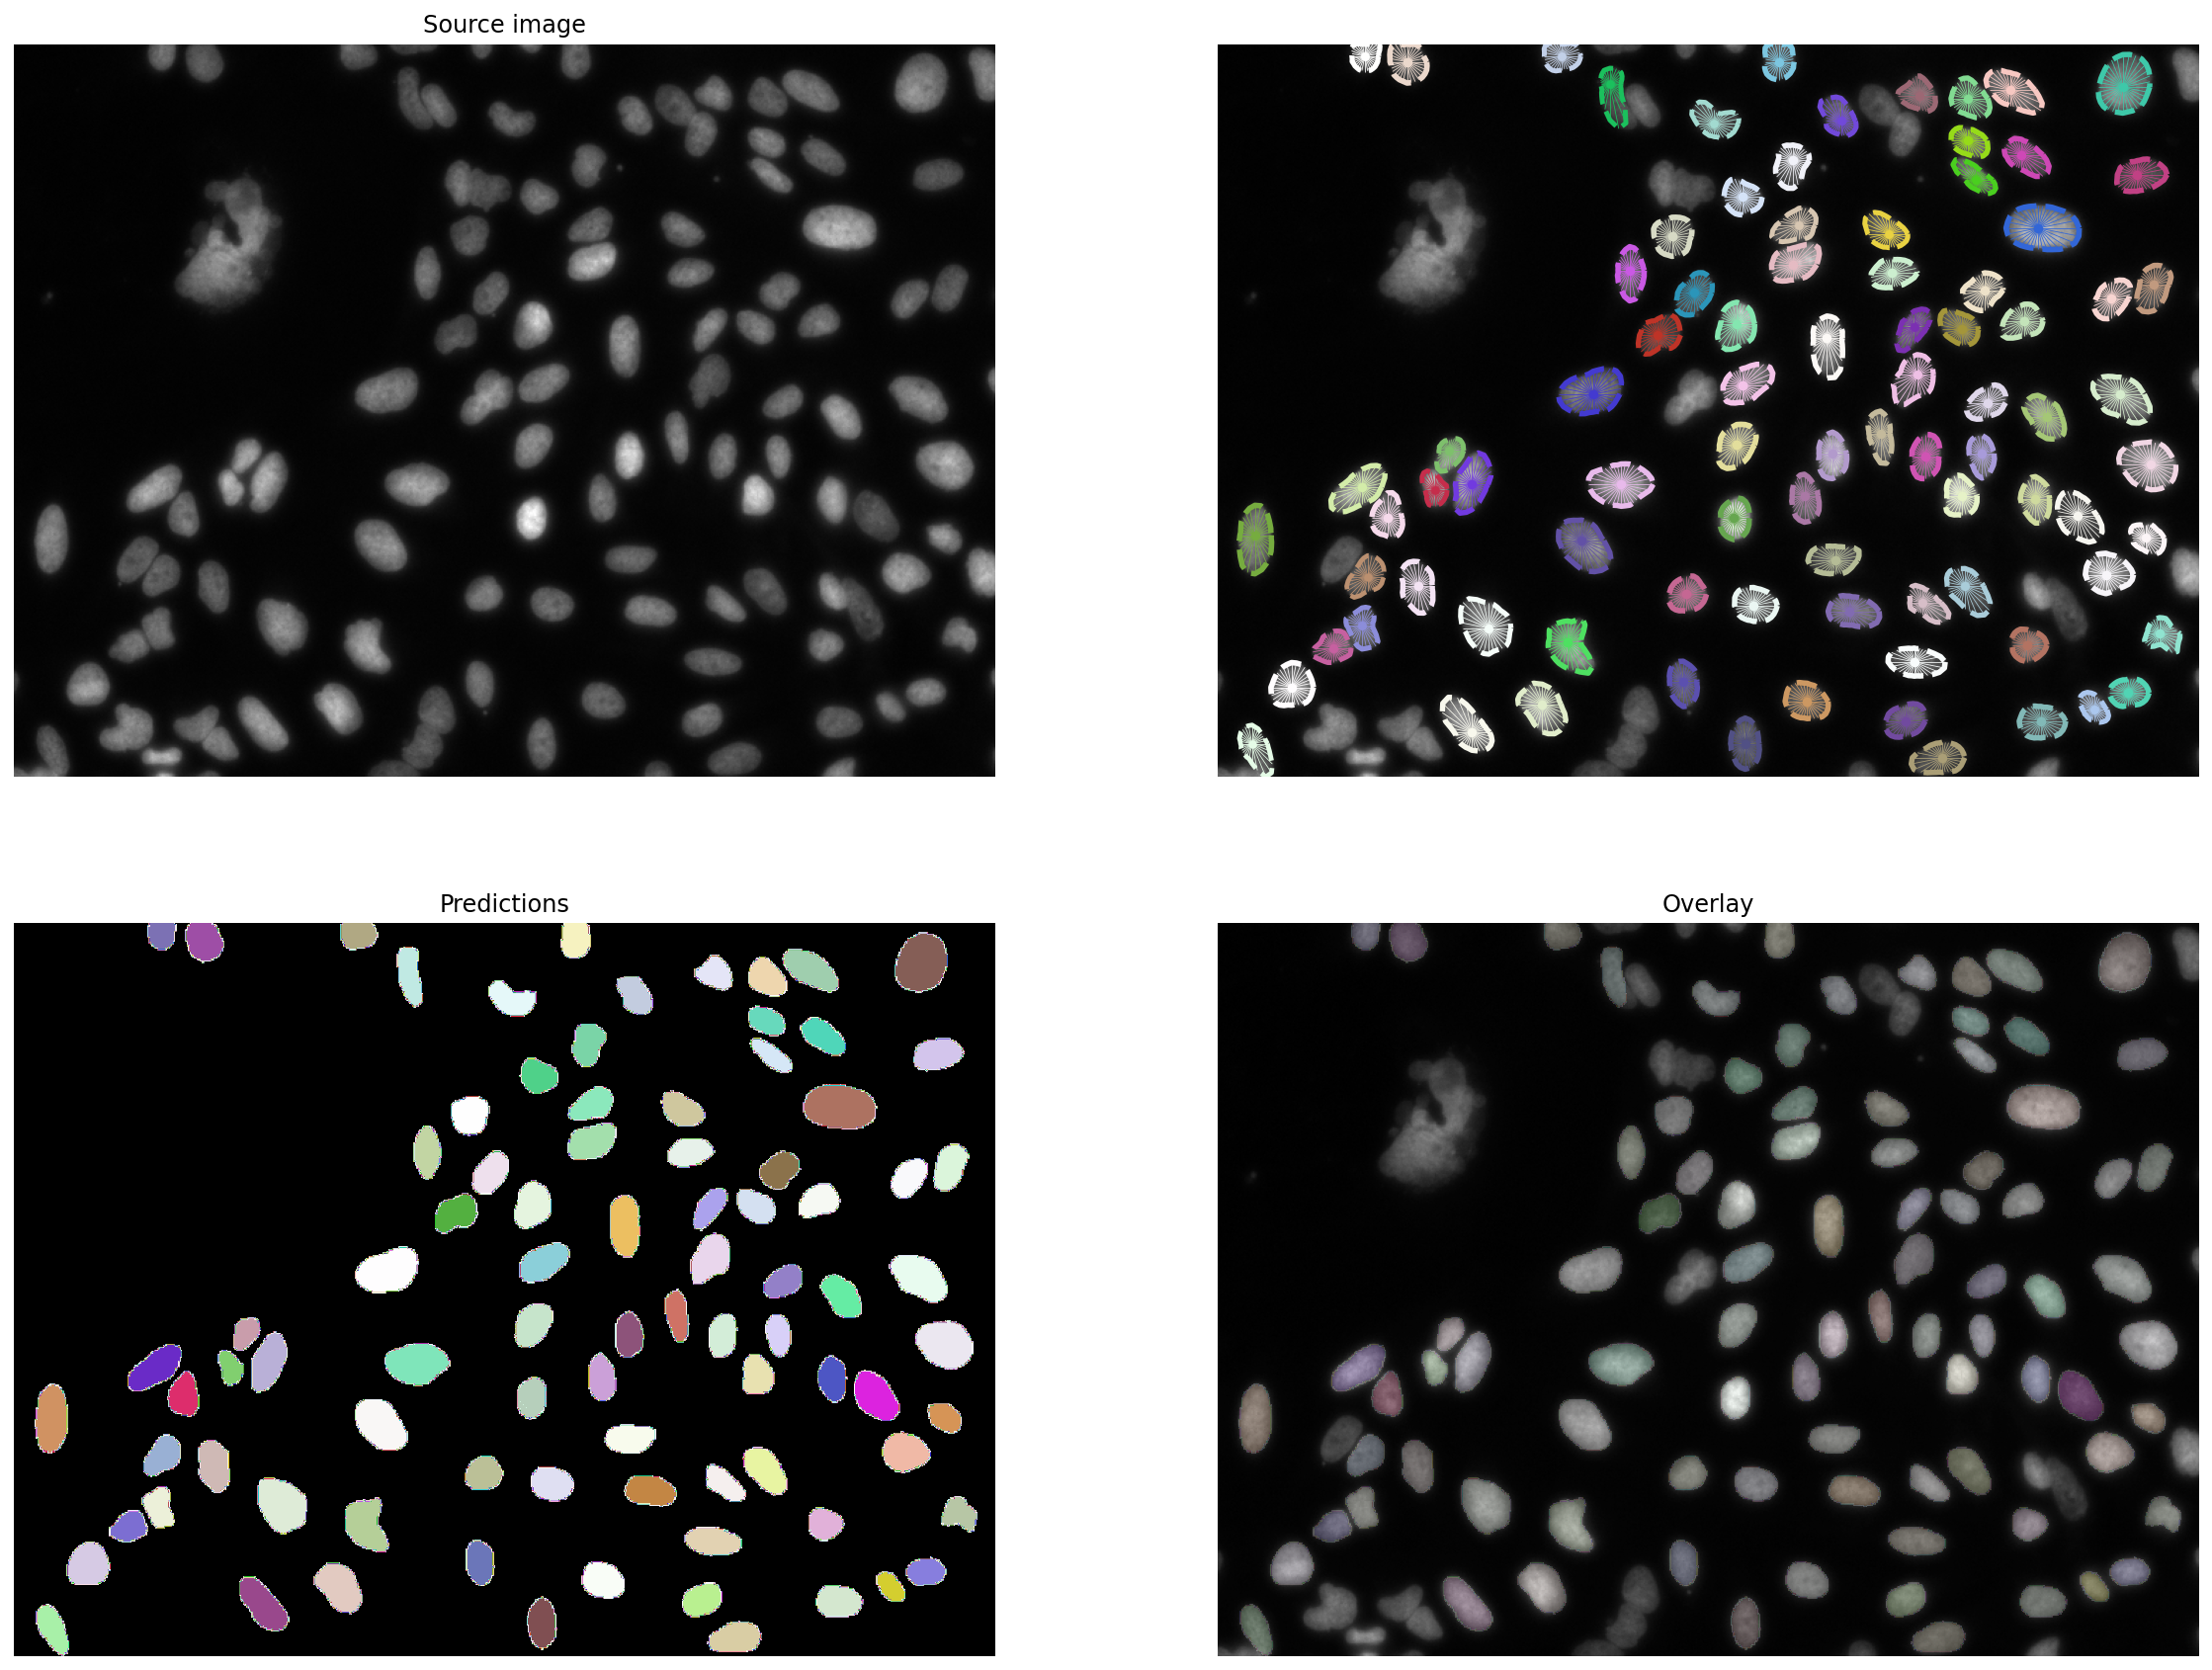

In [14]:
# Displaying the first image as example
plt.figure(figsize=(20,15))
plt.subplot(2,2,1); plt.imshow(X[0],cmap='gray', norm=matplotlib.colors.Normalize());   plt.axis('off'); plt.title('Source image')
plt.subplot(2,2,2);
img = X[0] if X[0].ndim==2 else X[0][...,0]
coord, points, prob = details[0]['coord'], details[0]['points'], details[0]['prob']
plt.imshow(img, cmap='gray'); plt.axis('off')
a = plt.axis()
_draw_polygons(coord, points, prob, show_dist=True)
plt.axis(a)

plt.subplot(2,2,3); plt.imshow(Labels[0],cmap=lbl_cmap, norm=matplotlib.colors.Normalize());   plt.axis('off'); plt.title('Predictions')
plt.subplot(2,2,4); plt.title('Overlay'); plt.axis('off');
plt.imshow(X[0] if X[0].ndim==2 else X[0][...,0], clim=(0,1), cmap='gray', norm=matplotlib.colors.Normalize())
plt.imshow(Labels[0], cmap=lbl_cmap, norm=matplotlib.colors.Normalize(), alpha=0.2)



In [15]:
# clearing memory
del predictions, details

# Segmentation

In [16]:
with mp.Pool() as pool:
    Labels = pool.map(im_ClearBorder,Labels)

In [17]:
with mp.Pool() as pool:  
    Crops = pool.starmap(im_segment,zip(Labels,X))

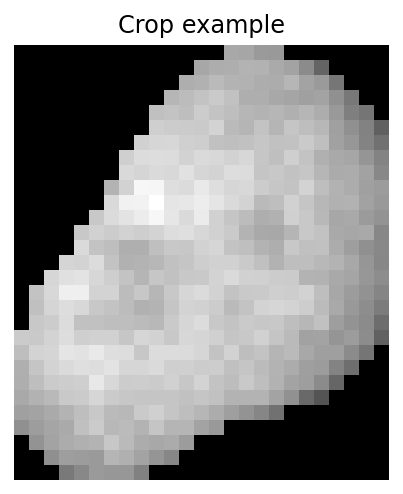

In [18]:
if type(Crops[0])==np.ndarray:
    plt.imshow(Crops[0], cmap='gray', norm=matplotlib.colors.Normalize()); plt.axis('off'); plt.title('Crop example')
else:
    plt.imshow(Crops[0][0], cmap='gray', norm=matplotlib.colors.Normalize()); plt.axis('off'); plt.title('Crop example')
    

In [19]:
# clearing memory
del Labels, X

# Saving the segments

In [20]:
# Defining save_paths

assert len(Crops)==len(ImportDetails), 'Output is inconsistent with number of input files!'
save_paths = []
EmptyImgs=[]
EmptyIdx=[]
for I,single_source in enumerate(Crops):
    if type(single_source)!=type(None):
        source_info = ImportDetails[I]
        filename = source_info['File']
        field = filename[filename.find(source_info['Well'])+len(source_info['Well']):]
        field = field[:field.find('_')]
        save_paths.extend([os.path.abspath(os.path.join(
            Segmented_dir,sanitize_filename(source_info['Compound Name']),
            sanitize_filename(f"{source_info['Plate']}{source_info['Well']}{field}_{i}_{source_info['Compound Name']}.tif")
        )) for i in range(len(single_source))])
    else:
        EmptyIdx.append(I)
        source_info = ImportDetails[I]
        EmptyImgs.append(os.path.abspath(os.path.join(
            Local_ImgPath,
            str(source_info['Plate']+'-'+ChannelOfInterest[0]),
            source_info['File']
        )))

Crops=np.delete(Crops,EmptyIdx)
ImportDetails=np.delete(ImportDetails,EmptyIdx)

print('\nNo. of empty images = ',str(len(EmptyImgs)))        
print('Empty paths :')
for path in EmptyImgs: print(path)
    
print('No. of save paths = ',str(len(save_paths)))
print('1st save path :\n',save_paths[0])


No. of empty images =  0
Empty paths :
No. of save paths =  2957
1st save path :
 \\deptnas.nus.edu.sg\BIE\MBELab\jokhun\Pro 1\U2OS small mol screening\Segmented_SmallMol\O-1918\24277_a02_s3_0_O-1918.tif


C:\Users\biejds\Anaconda3\envs\StarDist\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:
# Restructuring Crops such that each element is an image rather than a list of images
Crops = [crop for single_source in Crops for crop in single_source]
print('No. of crops = ',str(len(Crops)))

No. of crops =  2957


In [59]:
# saving the segments
img_size=(64,64) # desired image size. Use None to skip padding and save with original size

assert len(Crops)==len(save_paths), 'No. of crops is inconsistent with number of save paths!'
with mp.Pool() as pool:
    pool.starmap(Pad_n_Save,zip(save_paths,Crops,[img_size for save_path in save_paths]))

print('Saving complete!')

Saving complete!


### Run on loop with selected slices

In [ ]:
Run_on_loop = False

In [ ]:
if Run_on_loop:
    start=1450
    end=8000
    step=10
    
    selection = []
    lower = start
    upper = lower + step
    while upper <= end:
        selection.append(slice(lower,upper))
        lower += step
        upper += step

    selection

In [ ]:
if Run_on_loop:    
    from StarDist_Segment_loop import StarDist_Segment_loop
    from contextlib import redirect_stdout
    import io
    
    for i,select in enumerate(selection):
        print(f'\nRunning {select}! - slice {i+1} of {len(selection)}')
        with redirect_stdout(io.StringIO()):
            StarDist_Segment_loop (GPU_id=0, compound_selection=select)
        print(f'Completed {select}!')